# Let's go Pythonic...

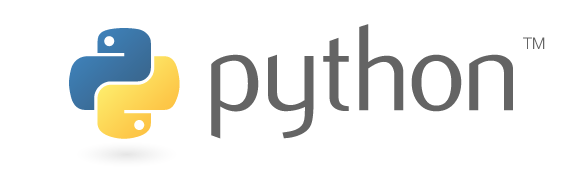

The aim of this notebook is to report the present status of the development of a more pythonic working flow to submit jobs to HTCondor, through a practical example. 

This notebook represents the 'API' of our tool, even though all the process cannot be automatic and recquires actions from the user, especially in the preliminairy steps. The goal is to present a tool that wil be very general, allowing the user to prepare the jobs they want to submit, and to organize the related data in a practical way. 

In this simple example, the goal is to match a FODO cell to different tunes, and to get back the quadrupole stregths, the typical kind of operation that recquires the use of a batch system ;) 

In [20]:
from pyHTC.Study import *
import pyHTC.toolkit as toolbox

In [21]:
# Definition of the study 

myName = 'myStudy'
myPath = '/afs/cern.ch/user/a/apoyet/public/BB_Meeting_Example'
myExe = '/afs/cern.ch/user/a/apoyet/public/BB_Meeting_Example/myExecutable.sh'
mySubFileName = 'mySubFile'

myStudy = StudyObj(myName, myPath, myExe, mySubFileName , arguments='$(input_file)', output_dir='output/', error_dir='error/',
                   log_dir = 'log/')

In [22]:
# Let's define the scans to be performed
# In our case, they are the horizontal and vertical tunes
# We store those parameters in a dictionnary 

myParam = {'X':[.25, .27], 'Y':[.25, .27]}

# NB: in fine, this would be a DF...
# And let's make the combination...

myStudy.define_study(myParam)

In [23]:
# One can access the parameters and their values

print('The parameters are : {}'.format(myStudy.parameters_keys))
print('Their values are : {}'.format(myStudy.parameters_values))

The parameters are : ['Y', 'X']
Their values are : [[0.25, 0.27], [0.25, 0.27]]


In [24]:
# One has now to create the input files... 

myTemplate = 'myScript.py'
myMaskedParam = toolbox.getMaskedParameterList(myTemplate, tag='%MASKED_')
print(myMaskedParam)

['%MASKED_Q1' '%MASKED_Q2' '%MASKED_output_file']


In [25]:
# Creation of the input files

for x in myStudy.parameters['X']:
    for y in myStudy.parameters['Y']:
        myMachineParam = {}
        myMachineParam.update({
            '%MASKED_Q1' : x,
            '%MASKED_Q2' : y, 
            '%MASKED_output_file' : '/afs/cern.ch/user/a/apoyet/public/BB_Meeting_Example/mad_output/my_k_table_{0}_{1}'.format(x,y)
        })
        myInputFile = 'input/{0}_{1}_{2}.in'.format(myStudy.name, x, y)
        toolbox.unmask(myTemplate, myMaskedParam, myMachineParam, myInputFile)

In [26]:
# Creating the submission file corresponding to the STUDY 
# NB : MULTIPLE JOBS SUBMISSION

myStudy.submit2file(myStudy.submit2str())

In [27]:
# One can display the submission file

myStudy.display_subfile()

executable = /afs/cern.ch/user/a/apoyet/public/BB_Meeting_Example/myExecutable.sh
arguments = $(input_file)
output = output/myStudy.$(ClusterId).$(ProcId).out
error = error/myStudy.$(ClusterId).$(ProcId).err
log = log/myStudy.$(ClusterId).log
universe = vanilla
queue input_file matching files /afs/cern.ch/user/a/apoyet/public/BB_Meeting_Example/input/myStudy_*.in


In [28]:
# And...... SUBMISSION

myStudy.submit2HTCondor()

Submitting job(s)....
4 job(s) submitted to cluster 3630035.



In [36]:
# Monitoring the jobs... :) 

myStudy.condor_q()



-- Schedd: bigbird16.cern.ch : <188.184.90.62:9618?... @ 07/13/19 13:15:52
OWNER  BATCH_NAME        SUBMITTED   DONE   RUN    IDLE  TOTAL JOB_IDS
apoyet CMD: myExecuta   7/13 13:06      _      _      4      4 3630035.0-3

4 jobs; 0 completed, 0 removed, 4 idle, 0 running, 0 held, 0 suspended



In [11]:
# The idea then is to generate a pandas DataFrame containing the different points (or JOBS) of the study
# The DF will be used as a reference afterwards to retrieve which job was made which which parameters
# It should therefore contains the paths of the corresponding files

df = myStudy.get_studyDF()

In [12]:
# Let's print the DF

df

Y     X                 Input  \
myStudy_0.25_0.25  0.25  0.25  myStudy_0.25_0.25.in   
myStudy_0.25_0.27  0.25  0.27  myStudy_0.25_0.27.in   
myStudy_0.27_0.25  0.27  0.25  myStudy_0.27_0.25.in   
myStudy_0.27_0.27  0.27  0.27  myStudy_0.27_0.27.in   

                                         Output                        Error  \
myStudy_0.25_0.25  output/myStudy.3630032.0.out  error/myStudy.3630032.0.err   
myStudy_0.25_0.27  output/myStudy.3630032.1.out  error/myStudy.3630032.1.err   
myStudy_0.27_0.25  output/myStudy.3630032.2.out  error/myStudy.3630032.2.err   
myStudy_0.27_0.27  output/myStudy.3630032.3.out  error/myStudy.3630032.3.err   

                                       Log ProcID  
myStudy_0.25_0.25  log/myStudy.3630032.log      0  
myStudy_0.25_0.27  log/myStudy.3630032.log      1  
myStudy_0.27_0.25  log/myStudy.3630032.log      2  
myStudy_0.27_0.27  log/myStudy.3630032.log      3